In [2]:
import sys

sys.path.insert(0, r"..\..\..\src")

import tranqu
import inspect

print("Now using tranqu:", inspect.getfile(tranqu))


Now using tranqu: c:\Users\tochi\Documents\Krasnovia\tranqu\tests\tranqu\transpiler\..\..\..\src\tranqu\__init__.py


In [3]:
from tranqu import Tranqu

from qiskit import QuantumCircuit
from qiskit.visualization import *

tranqu = Tranqu()

Circuit depth:  6


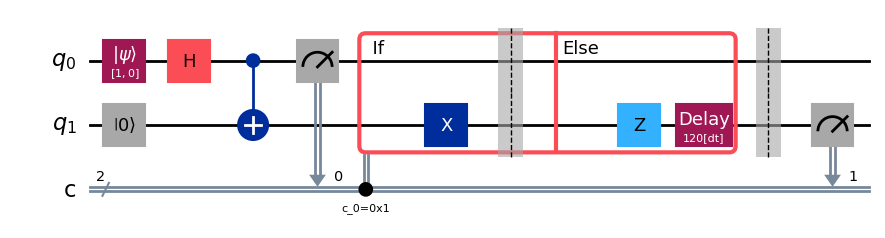

In [4]:
def solve() -> QuantumCircuit:
    # 量子2 / 古典2（分岐条件に使うので clbits を用意）
    qc = QuantumCircuit(2, 2)

    # 非ユニタリ系（統計で除外されるはず）
    qc.initialize([1.0, 0.0], 0)  # |0> を明示（initialize の存在をテスト）
    qc.reset(1)

    # ユニタリ
    qc.h(0)
    qc.cx(0, 1)

    # 計測（分岐条件に使う）
    qc.measure(0, 0)

    # ---- if/else 分岐（Qiskit 2.x：builder の context manager 形）----
    # 条件: clbit0 == 1
    with qc.if_test((qc.clbits[0], 1)) as else_:
        # 真：X を適用
        qc.x(1)
        qc.barrier()
    # 偽ブロック
    with else_:
        qc.z(1)
        qc.delay(120, 1)  # 120 dt を qubit 1 に入れる（delay も非ユニタリ扱い）

    # 追加の可視化系（非ユニタリ）
    qc.barrier()
    qc.measure(1, 1)

    """
    qc = QuantumCircuit(1,1)
    
    with qc.for_loop(range(3)):
        qc.h(0)
        
    with qc.while_loop((qc.clbits[0],0)):
        qc.x(0)
        qc.measure(0,0)
    """

    return qc


circuit = solve()

print("Circuit depth: ", circuit.depth())

circuit.draw(output="mpl")

In [5]:
result = tranqu.transpile(
    program=circuit,
    program_lib="qiskit",
    transpiler_lib="qiskit",
)

for instruction in circuit.data:
    print(instruction.operation.name, len(instruction.qubits))

initialize 1
reset 1
h 1
cx 2
measure 1
if_else 2
barrier 2
measure 1


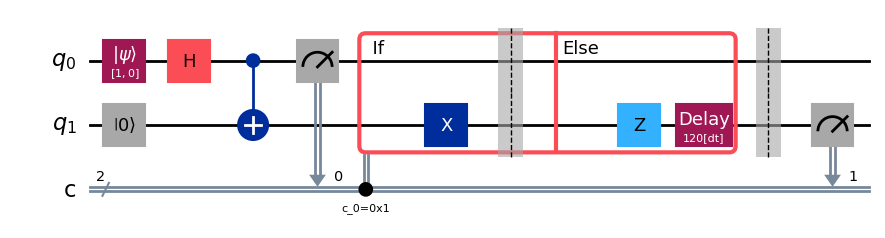

In [6]:
result.transpiled_program.draw(output="mpl")

In [7]:
print(result.stats)

{'before': {'n_qubits': 2, 'n_gates': 2, 'n_gates_1q': 1, 'n_gates_2q': 1, 'depth': 6}, 'after': {'n_qubits': 2, 'n_gates': 2, 'n_gates_1q': 1, 'n_gates_2q': 1, 'depth': 6}}


In [8]:
print(result.virtual_physical_mapping)

{'qubit_mapping': {0: 0, 1: 1}, 'bit_mapping': {0: 0, 1: 1}}


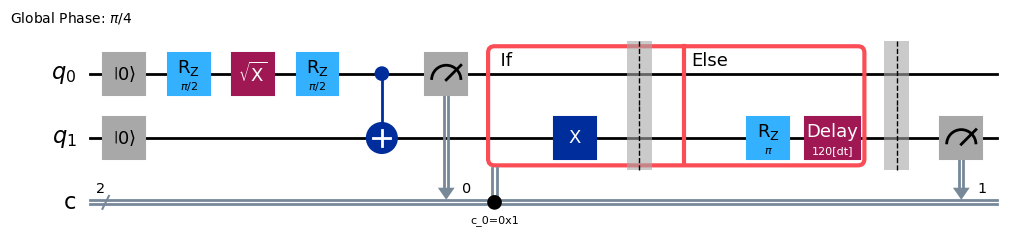

In [9]:
options = {"basis_gates": ["id", "sx", "x", "rz", "cx"]}
result = tranqu.transpile(
    program=circuit,
    program_lib="qiskit",
    transpiler_lib="qiskit",
    transpiler_options=options,
)
result.transpiled_program.draw(output="mpl")

In [10]:
print(result.stats)

{'before': {'n_qubits': 2, 'n_gates': 2, 'n_gates_1q': 1, 'n_gates_2q': 1, 'depth': 6}, 'after': {'n_qubits': 2, 'n_gates': 4, 'n_gates_1q': 3, 'n_gates_2q': 1, 'depth': 8}}
